In [1]:
import tensorflow as tf
import torch
import onnx
from onnx_tf.backend import prepare
from torchsummary import summary


c:\Users\hp\miniconda3\envs\myenv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class BasicLayer(nn.Module):
	"""
	  Basic Convolutional Layer: Conv2d -> BatchNorm -> ReLU
	"""
	def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
		super().__init__()
		self.layer = nn.Sequential(
									  nn.Conv2d( in_channels, out_channels, kernel_size, padding = padding, stride=stride, dilation=dilation, bias = bias),
									  nn.BatchNorm2d(out_channels, affine=False),
									  nn.ReLU(inplace = True),
									)

	def forward(self, x):
	  return self.layer(x)

class XFeatModel(nn.Module):
	"""
	   Implementation of architecture described in 
	   "XFeat: Accelerated Features for Lightweight Image Matching, CVPR 2024."
	"""

	def __init__(self):
		super().__init__()
		self.norm = nn.InstanceNorm2d(1)


		########### ⬇️ CNN Backbone & Heads ⬇️ ###########

		self.skip1 = nn.Sequential(	 nn.AvgPool2d(4, stride = 4),
			  						 nn.Conv2d (1, 24, 1, stride = 1, padding=0) )

		self.block1 = nn.Sequential(
										BasicLayer( 1,  4, stride=1),
										BasicLayer( 4,  8, stride=2),
										BasicLayer( 8,  8, stride=1),
										BasicLayer( 8, 24, stride=2),
									)

		self.block2 = nn.Sequential(
										BasicLayer(24, 24, stride=1),
										BasicLayer(24, 24, stride=1),
									 )

		self.block3 = nn.Sequential(
										BasicLayer(24, 64, stride=2),
										BasicLayer(64, 64, stride=1),
										BasicLayer(64, 64, 1, padding=0),
									 )
		self.block4 = nn.Sequential(
										BasicLayer(64, 64, stride=2),
										BasicLayer(64, 64, stride=1),
										BasicLayer(64, 64, stride=1),
									 )

		self.block5 = nn.Sequential(
										BasicLayer( 64, 128, stride=2),
										BasicLayer(128, 128, stride=1),
										BasicLayer(128, 128, stride=1),
										BasicLayer(128,  64, 1, padding=0),
									 )

		self.block_fusion =  nn.Sequential(
										BasicLayer(64, 64, stride=1),
										BasicLayer(64, 64, stride=1),
										nn.Conv2d (64, 64, 1, padding=0)
									 )

		self.heatmap_head = nn.Sequential(
										BasicLayer(64, 64, 1, padding=0),
										BasicLayer(64, 64, 1, padding=0),
										nn.Conv2d (64, 1, 1),
										nn.Sigmoid()
									)


		self.keypoint_head = nn.Sequential(
										BasicLayer(64, 64, 1, padding=0),
										BasicLayer(64, 64, 1, padding=0),
										BasicLayer(64, 64, 1, padding=0),
										nn.Conv2d (64, 65, 1),
									)


  		########### ⬇️ Fine Matcher MLP ⬇️ ###########

		self.fine_matcher =  nn.Sequential(
											nn.Linear(128, 512),
											nn.BatchNorm1d(512, affine=False),
									  		nn.ReLU(inplace = True),
											nn.Linear(512, 512),
											nn.BatchNorm1d(512, affine=False),
									  		nn.ReLU(inplace = True),
											nn.Linear(512, 512),
											nn.BatchNorm1d(512, affine=False),
									  		nn.ReLU(inplace = True),
											nn.Linear(512, 512),
											nn.BatchNorm1d(512, affine=False),
									  		nn.ReLU(inplace = True),
											nn.Linear(512, 64),
										)

	def _unfold2d(self, x, ws = 2):
		"""
			Unfolds tensor in 2D with desired ws (window size) and concat the channels
		"""
		B, C, H, W = x.shape
		x = x.unfold(2,  ws , ws).unfold(3, ws,ws)                             \
			.reshape(B, C, H//ws, W//ws, ws**2)
		return x.permute(0, 1, 4, 2, 3).reshape(B, -1, H//ws, W//ws)


	def forward(self, x):
		"""
			input:
				x -> torch.Tensor(B, C, H, W) grayscale or rgb images
			return:
				feats     ->  torch.Tensor(B, 64, H/8, W/8) dense local features
				keypoints ->  torch.Tensor(B, 65, H/8, W/8) keypoint logit map
				heatmap   ->  torch.Tensor(B,  1, H/8, W/8) reliability map

		"""
		#dont backprop through normalization
		with torch.no_grad():
			x = x.mean(dim=1, keepdim = True)
			x = self.norm(x)

		#main backbone
		x1 = self.block1(x)
		x2 = self.block2(x1 + self.skip1(x))
		x3 = self.block3(x2)
		x4 = self.block4(x3)
		x5 = self.block5(x4)

		#pyramid fusion
		x4 = F.interpolate(x4, (x3.shape[-2], x3.shape[-1]), mode='bilinear')
		x5 = F.interpolate(x5, (x3.shape[-2], x3.shape[-1]), mode='bilinear')
		feats = self.block_fusion( x3 + x4 + x5 )

		#heads
		heatmap = self.heatmap_head(feats) # Reliability map
		keypoints = self.keypoint_head(self._unfold2d(x, ws=8)) #Keypoint map logits

		return feats, keypoints, heatmap


In [3]:
import numpy as np

dev = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
net = XFeatModel().to(dev)
        
net.load_state_dict(torch.load('./weights/xfeat.pt'))

X_test = np.random.randn(20, 800, 608).astype(np.float32)

dummy_input = torch.from_numpy(X_test[0].reshape(1, 1, 800, 608)).float().to(dev)  # Batch size of 1, with an extra channel dimension
dummy_output = net(dummy_input)
print(dummy_output)

# Export to ONNX format
torch.onnx.export(net, dummy_input, './weights/model_simple.onnx', input_names=['test_input'], output_names=['test_output'])

C:\Users\hp\AppData\Local\Temp\ipykernel_1444\829969235.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./weights/xfeat.pt'))


(tensor([[[[ 1.9935,  1.9827,  2.4490,  ...,  2.7937,  2.9708,  3.2615],
          [ 2.4358,  2.2065,  3.4190,  ...,  3.3089,  3.6938,  3.7903],
          [ 2.5983,  2.7325,  3.8894,  ...,  2.9930,  3.3625,  3.9733],
          ...,
          [ 2.5795,  3.3498,  4.0857,  ...,  0.8220,  1.6882,  1.6122],
          [ 2.4918,  3.0690,  3.6391,  ...,  0.7859,  1.5072,  1.5972],
          [ 2.6339,  3.4734,  3.9611,  ...,  1.8250,  1.9684,  2.6227]],

         [[-1.8873, -1.7629, -1.5999,  ..., -2.1074, -1.8390, -1.6416],
          [-1.9378, -1.8752, -1.6804,  ..., -2.3719, -2.3393, -1.7625],
          [-2.1232, -1.8372, -1.7968,  ..., -2.6441, -3.1547, -2.1336],
          ...,
          [-1.2601, -1.9532, -1.7436,  ..., -0.8744, -1.0840, -0.9058],
          [-1.9131, -2.8540, -2.4948,  ..., -0.6011, -0.7142, -0.5717],
          [-1.1015, -2.1265, -1.8358,  ...,  0.5659, -0.3559, -0.1700]],

         [[-0.7144, -1.4179, -2.2751,  ..., -0.9434, -0.5724, -0.7672],
          [-1.6681, -2.8668, 

c:\Users\hp\miniconda3\envs\myenv\lib\site-packages\torch\onnx\symbolic_helper.py:1531: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'instance_norm' is set to train=True. Exporting with train=True.
  warnings.warn(


In [4]:
# Load the model and its weights
net = XFeatModel().to(dev)
net.load_state_dict(torch.load('./weights/xfeat.pt'))

# Create a dummy input with the shape (1, 3, 480, 640)
dummy_input = torch.randn(1, 3, 480, 640, device=dev)

# Optionally, you can check the output
dummy_output = net(dummy_input)
print(dummy_output)

# Export the model to ONNX format
torch.onnx.export(
    net, 
    dummy_input, 
    './weights/model_simple.onnx',
    input_names=['test_input'],
    output_names=['test_output'],
    export_params=True,  # Export the trained parameters
    opset_version=12,    # ONNX opset version (you can choose according to your needs)
    do_constant_folding=False,  # Whether to fold constants for optimization
    dynamic_axes={
        'test_input': {0: 'batch_size'},  # Variable batch size
        'test_output': {0: 'batch_size'}  # Variable batch size
    }
)

C:\Users\hp\AppData\Local\Temp\ipykernel_1444\2931410386.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./weights/xfeat.pt'))


(tensor([[[[ 2.0429,  2.0751,  2.7110,  ...,  2.5637,  2.8497,  3.1169],
          [ 2.2302,  2.3369,  4.0044,  ...,  3.3140,  3.7896,  4.1522],
          [ 2.7945,  3.3579,  4.4605,  ...,  3.1975,  3.9799,  4.5383],
          ...,
          [ 2.3023,  3.2868,  3.9855,  ...,  1.4351,  2.0857,  1.9563],
          [ 2.0496,  2.3789,  3.6429,  ...,  1.4296,  1.8734,  1.5088],
          [ 2.0182,  2.7893,  3.6996,  ...,  0.9894,  1.6685,  1.8546]],

         [[-1.4128, -2.1542, -1.9796,  ..., -2.0406, -1.7984, -1.4717],
          [-1.8793, -1.5273, -1.2732,  ..., -2.3919, -2.2580, -1.6899],
          [-1.8530, -1.5059, -1.5702,  ..., -2.3976, -2.7612, -1.6402],
          ...,
          [-1.7468, -2.2380, -1.7260,  ..., -0.9426, -1.5519, -1.0316],
          [-2.4974, -2.7083, -2.4247,  ..., -2.1692, -1.8448, -1.4998],
          [-1.2959, -2.3545, -2.1141,  ..., -1.7102, -0.7927, -0.8185]],

         [[-0.3779, -0.8449, -1.2185,  ..., -1.2664, -0.6083, -1.0680],
          [-1.5750, -2.8422, 

In [6]:
# Load ONNX model and convert to TensorFlow format
model_onnx = onnx.load('./weights/model_simple.onnx')

tf_rep = prepare(model_onnx)
# Export model as .pb file
tf_rep.export_graph('./weights/model_simple.pb')

INFO:tensorflow:Assets written to: ./weights/model_simple.pb\assets


INFO:tensorflow:Assets written to: ./weights/model_simple.pb\assets


In [7]:
model_dir = './weights/model_simple.pb'  # Path to the saved model directory
model = tf.saved_model.load(model_dir)


In [8]:
print("Available functions:")
for func in model.signatures:
    print(func)

Available functions:
serving_default


In [9]:
# Access the default serving function
infer = model.signatures['serving_default']

# Print input and output details
print("Inputs:")
for input_tensor in infer.inputs:
    print(f"{input_tensor.name}: {input_tensor.shape}")

print("Outputs:")
for output_tensor in infer.outputs:
    print(f"{output_tensor.name}: {output_tensor.shape}")

Inputs:
test_input:0: (None, 3, 480, 640)
unknown:0: (4, 1, 3, 3)
unknown_0:0: (4,)
unknown_1:0: (4,)
unknown_2:0: (8, 4, 3, 3)
unknown_3:0: (8,)
unknown_4:0: (8,)
unknown_5:0: (8, 8, 3, 3)
unknown_6:0: (8,)
unknown_7:0: (8,)
unknown_8:0: (24, 8, 3, 3)
unknown_9:0: (24,)
unknown_10:0: (24,)
unknown_11:0: (24, 1, 1, 1)
unknown_12:0: (24,)
unknown_13:0: (24, 24, 3, 3)
unknown_14:0: (24,)
unknown_15:0: (24,)
unknown_16:0: (24, 24, 3, 3)
unknown_17:0: (24,)
unknown_18:0: (24,)
unknown_19:0: (64, 24, 3, 3)
unknown_20:0: (64,)
unknown_21:0: (64,)
unknown_22:0: (64, 64, 3, 3)
unknown_23:0: (64,)
unknown_24:0: (64,)
unknown_25:0: (64, 64, 1, 1)
unknown_26:0: (64,)
unknown_27:0: (64,)
unknown_28:0: (64, 64, 3, 3)
unknown_29:0: (64,)
unknown_30:0: (64,)
unknown_31:0: (64, 64, 3, 3)
unknown_32:0: (64,)
unknown_33:0: (64,)
unknown_34:0: (64, 64, 3, 3)
unknown_35:0: (64,)
unknown_36:0: (64,)
unknown_37:0: (128, 64, 3, 3)
unknown_38:0: (128,)
unknown_39:0: (128,)
unknown_40:0: (128, 128, 3, 3)
unkno

In [10]:
# Get the concrete function from the model
concrete_func = model.signatures['serving_default']

# Print graph details
print("Concrete function details:")
print(concrete_func.graph.as_graph_def())


Concrete function details:
node {
  name: "test_input"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "test_input"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 3
        }
        dim {
          size: 480
        }
        dim {
          size: 640
        }
      }
    }
  }
}
node {
  name: "unknown"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 4
        }
        dim {
          size: 1
        }
        dim {
          size: 3
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "unknown_0"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
    

In [11]:
infer = model.signatures['serving_default']

np.random.seed(42)
# Create a dummy input using NumPy
dummy_input_np = np.random.uniform(low=0.0, high=1.0, size=(1, 3, 480, 640)).astype(np.float32)
# Convert the NumPy array to a PyTorch tensor
dummy_input_tf = tf.convert_to_tensor(dummy_input_np)

#print(dummy_input)
# Run inference
output = infer(dummy_input_tf)

print("Model output:", output)


Model output: {'test_output': <tf.Tensor: shape=(1, 64, 60, 80), dtype=float32, numpy=
array([[[[ 2.7716923 ,  2.9181218 ,  3.5422735 , ...,  4.0015283 ,
           3.9146285 ,  4.9634204 ],
         [ 2.4328227 ,  2.5331857 ,  2.7827773 , ...,  4.631966  ,
           4.482542  ,  5.528987  ],
         [ 2.5868373 ,  2.2943256 ,  2.8224418 , ...,  4.707311  ,
           4.746748  ,  5.772123  ],
         ...,
         [ 1.3212066 ,  0.87544906,  0.4736309 , ...,  3.2334828 ,
           2.9983416 ,  3.575602  ],
         [ 0.9550823 ,  0.64715517,  1.0662553 , ...,  2.9251895 ,
           3.1295605 ,  3.5897496 ],
         [ 0.81406665,  0.7910178 ,  0.6212313 , ...,  3.2118843 ,
           3.4631934 ,  3.5685563 ]],

        [[-1.2004908 , -2.2954364 , -1.9417119 , ..., -1.6244137 ,
          -1.1982563 ,  0.02280033],
         [-0.9044695 , -1.8866334 , -1.1970613 , ..., -2.0385873 ,
          -2.0500245 , -0.29453492],
         [-1.5509524 , -2.7927127 , -1.4286678 , ..., -2.2570333 

In [12]:
x = torch.randn(1,3,480,640)
net = XFeatModel().to(dev)
summary(net, input_size=(3, 480, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    InstanceNorm2d-1          [-1, 1, 480, 640]               0
            Conv2d-2          [-1, 4, 480, 640]              36
       BatchNorm2d-3          [-1, 4, 480, 640]               0
              ReLU-4          [-1, 4, 480, 640]               0
        BasicLayer-5          [-1, 4, 480, 640]               0
            Conv2d-6          [-1, 8, 240, 320]             288
       BatchNorm2d-7          [-1, 8, 240, 320]               0
              ReLU-8          [-1, 8, 240, 320]               0
        BasicLayer-9          [-1, 8, 240, 320]               0
           Conv2d-10          [-1, 8, 240, 320]             576
      BatchNorm2d-11          [-1, 8, 240, 320]               0
             ReLU-12          [-1, 8, 240, 320]               0
       BasicLayer-13          [-1, 8, 240, 320]               0
           Conv2d-14         [-1, 24, 1

In [13]:
net = XFeatModel().to(dev)
net.load_state_dict(torch.load('./weights/xfeat.pt',weights_only=True))
dummy_input = torch.tensor(dummy_input_np).to(dev)

output = net(dummy_input)
print(output)

(tensor([[[[ 2.0339,  2.0162,  2.4294,  ...,  2.9459,  2.7474,  3.0622],
          [ 2.2621,  2.2193,  3.5295,  ...,  3.5592,  3.6374,  4.0465],
          [ 2.5319,  2.6700,  3.6643,  ...,  3.3428,  3.3196,  3.8285],
          ...,
          [ 2.6655,  3.5698,  3.8302,  ...,  2.4511,  2.7391,  3.1545],
          [ 2.4450,  3.1618,  3.6899,  ...,  3.0513,  3.0640,  2.9057],
          [ 1.8802,  2.9788,  4.0835,  ...,  3.5376,  2.8929,  3.3399]],

         [[-1.7989, -1.6022, -1.8334,  ..., -2.0971, -1.8097, -1.1508],
          [-2.0277, -1.5544, -1.4291,  ..., -2.2789, -2.1056, -1.4540],
          [-1.9461, -1.8042, -1.7633,  ..., -2.5108, -2.5897, -1.8712],
          ...,
          [-0.8095, -1.4622, -1.1222,  ..., -1.7730, -1.3524, -1.5609],
          [-0.9608, -1.8014, -1.6007,  ..., -1.3224, -1.3463, -1.2188],
          [-0.6025, -1.3109, -1.1311,  ..., -0.2823, -0.2996, -0.3582]],

         [[-0.7027, -1.1888, -1.5610,  ..., -0.7867, -0.3383, -0.9603],
          [-1.6852, -2.7409, 

In [14]:
onnx_model = onnx.load("./weights/model_simple.onnx")  # load onnx model
output = prepare(onnx_model).run(dummy_input_np)  # run the loaded model
print(output)

Outputs(test_output=array([[[[ 2.7716923 ,  2.9181218 ,  3.5422735 , ...,  4.0015283 ,
           3.9146285 ,  4.9634204 ],
         [ 2.4328227 ,  2.5331857 ,  2.7827773 , ...,  4.631966  ,
           4.482542  ,  5.528987  ],
         [ 2.5868373 ,  2.2943256 ,  2.8224418 , ...,  4.707311  ,
           4.746748  ,  5.772123  ],
         ...,
         [ 1.3212066 ,  0.87544906,  0.4736309 , ...,  3.2334828 ,
           2.9983416 ,  3.575602  ],
         [ 0.9550823 ,  0.64715517,  1.0662553 , ...,  2.9251895 ,
           3.1295605 ,  3.5897496 ],
         [ 0.81406665,  0.7910178 ,  0.6212313 , ...,  3.2118843 ,
           3.4631934 ,  3.5685563 ]],

        [[-1.2004908 , -2.2954364 , -1.9417119 , ..., -1.6244137 ,
          -1.1982563 ,  0.02280033],
         [-0.9044695 , -1.8866334 , -1.1970613 , ..., -2.0385873 ,
          -2.0500245 , -0.29453492],
         [-1.5509524 , -2.7927127 , -1.4286678 , ..., -2.2570333 ,
          -1.2573503 , -0.7538762 ],
         ...,
         [ 0.1

In [15]:
# Converting a SavedModel to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_saved_model('./weights/model_simple.pb')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable LiteRT ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

In [16]:
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [17]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Step 3: Prepare the dummy input
np.random.seed(42)
dummy_input_np = np.random.uniform(low=0.0, high=1.0, size=(1, 3, 480, 640)).astype(np.float32)  # Shape in HWC format for TFLite
interpreter.set_tensor(input_details[0]['index'], dummy_input_np)

# Step 4: Run the inference
interpreter.invoke()

# Step 5: Get the model output
output = interpreter.get_tensor(output_details[0]['index'])
print("Model output:", output)

Model output: [[[[-0.17374077  0.6367105  -0.874497   ... -1.7740037  -0.02258542
    -3.9748898 ]
   [-0.49570012 -1.0216734  -0.7351361  ... -1.9915701  -2.39346
    -2.2506635 ]
   [-0.5824499   0.50718844  0.03219321 ...  1.1671302  -2.0963547
    -0.9427631 ]
   ...
   [-0.21512285 -2.5201912   0.5092685  ... -1.5460559  -0.25479528
    -2.0833611 ]
   [-1.0864445   0.16682479 -5.030627   ... -0.09988543 -2.7521334
    -2.0024688 ]
   [-0.0361529  -2.1273131  -0.2500229  ... -2.688341   -0.23123223
    -1.4341278 ]]

  [[-5.1211114   0.27479324  0.00592035 ... -1.6901201   0.8582487
    -1.2211893 ]
   [-0.9182242  -2.3704123   0.12963685 ... -0.9285667  -2.143021
    -2.3342202 ]
   [-2.160205    0.594993   -1.1496086  ...  1.6398246  -2.6674542
    -1.7010673 ]
   ...
   [-2.3163784  -1.4690528  -0.9395739  ... -1.0213172  -0.5925242
    -1.5779672 ]
   [-1.4269366  -1.5066587  -3.8390656  ... -2.9133096  -3.0389047
    -0.29341596]
   [-2.1909728  -1.2359558   0.83613193 ... -0

In [8]:
import tensorflow as tf
import cv2
import numpy as np

# Function to load images
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found: {image_path}")
    return image

# Load the TFLite model
def load_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

# Define paths
model_path = "model.tflite"
image1_path = './assets/ref.png'
image2_path = './assets/tgt.png'

# Load the model
interpreter = load_model(model_path)
print("Model loaded successfully.")

# Load the images
im1 = load_image(image1_path)
im2 = load_image(image2_path)
print("Images loaded successfully.")

# Display image shapes for confirmation
print(f"Image 1 shape: {im1.shape}")
print(f"Image 2 shape: {im2.shape}")


Model loaded successfully.
Images loaded successfully.
Image 1 shape: (600, 800, 3)
Image 2 shape: (600, 800, 3)


In [9]:
# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output details
print("Input details:", input_details)
print("Output details:", output_details)

# Extract input shape and type
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']

print(f"Input shape: {input_shape}")
print(f"Input dtype: {input_dtype}")


Input details: [{'name': 'serving_default_test_input:0', 'index': 0, 'shape': array([  1,   3, 480, 640]), 'shape_signature': array([ -1,   3, 480, 640]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 2240, 'shape': array([ 1, 65,  1,  1]), 'shape_signature': array([-1, 65, -1, -1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:1', 'index': 908, 'shape': array([ 1,  1, 60, 80]), 'shape_signature': array([-1,  1, 60, 80]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_p

In [13]:
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

TypeError: maketrans expected at least 1 argument, got 0

In [19]:
# Function to preprocess images
def preprocess_image(image, target_shape):
    batch_size, channels, height, width = target_shape
    
    # Resize the image to the target height and width
    resized_img = cv2.resize(image, (width, height))
    
    # Ensure image has 3 channels (RGB)
    if resized_img.shape[2] != channels:
        raise ValueError(f"Expected {channels} channels but got {resized_img.shape[2]} channels")

    # Convert to RGB if necessary
    if resized_img.shape[2] == 4:  # Check for RGBA
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_RGBA2RGB)
    
    # Normalize image
    img = resized_img.astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Add batch dimension
    img = np.transpose(img, (2, 0, 1))  # Change shape from [height, width, channels] to [channels, height, width]
    img = np.expand_dims(img, axis=0)  # Add batch dimension: Shape [1, channels, height, width]
    
    return img

# Preprocess images to match model's input shape
preprocessed_im1 = preprocess_image(im1, input_shape)
preprocessed_im2 = preprocess_image(im2, input_shape)

# Print shapes of preprocessed images
print(f"Preprocessed image 1 shape: {preprocessed_im1.shape}")
print(f"Preprocessed image 2 shape: {preprocessed_im2.shape}")


ValueError: not enough values to unpack (expected 4, got 3)

In [11]:
# Function to run inference
def run_inference(interpreter, input_tensor):
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output_tensor = interpreter.get_tensor(output_details[0]['index'])
    return output_tensor

# Run inference on both images
output_im1 = run_inference(interpreter, preprocessed_im1)
output_im2 = run_inference(interpreter, preprocessed_im2)

# Print output shapes
print(f"Output shape for image 1: {output_im1.shape}")
print(f"Output shape for image 2: {output_im2.shape}")


Output shape for image 1: (1, 65, 60, 80)
Output shape for image 2: (1, 65, 60, 80)


Keypoints in image 1: [[-2.502386    0.05047747]
 [-3.7273216  -0.44045928]
 [-2.4673986  -1.0775973 ]
 ...
 [-1.7928835  -1.1003293 ]
 [-0.04439843  1.0776917 ]
 [ 1.5744169   1.1095006 ]]
Keypoints in image 2: [[-2.6738868  -2.4964042 ]
 [-1.807442   -0.3679113 ]
 [-3.6559958  -2.1210015 ]
 ...
 [ 0.3869555  -0.19744456]
 [ 0.6034385   0.52127373]
 [-0.06129754  2.582758  ]]


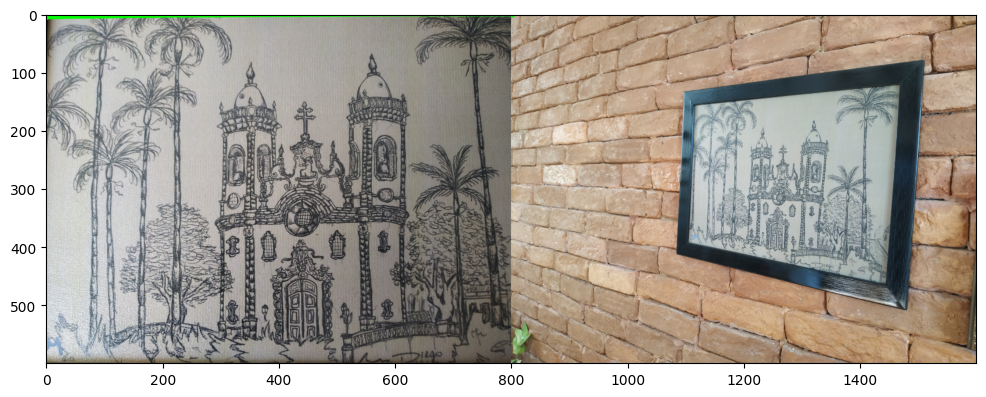

(<matplotlib.image.AxesImage at 0x1dd89e22fa0>, None)

In [24]:
import matplotlib.pyplot as plt

# Assuming output tensors contain keypoints
def extract_keypoints(output_tensor):
    # Convert output tensor to keypoints
    keypoints = output_tensor[0]  # Adjust this depending on your model's output format
    keypoints = np.array(keypoints).reshape(-1, 2)  # Reshape to [num_keypoints, 2]
    return keypoints

# Extract keypoints
mkpts_0 = extract_keypoints(output_im1)
mkpts_1 = extract_keypoints(output_im2)

# Debugging: Print keypoints
print(f"Keypoints in image 1: {mkpts_0}")
print(f"Keypoints in image 2: {mkpts_1}")


# Plot the keypoints
def plot_keypoints(image, keypoints):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, c='red', marker='o')
    plt.show()

plot_keypoints(im1, mkpts_0)
plot_keypoints(im2, mkpts_1)


Input details: [{'name': 'serving_default_test_input:0', 'index': 0, 'shape': array([  1,   3, 480, 640]), 'shape_signature': array([ -1,   3, 480, 640]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Preprocessed image 1 shape: (1, 3, 480, 640)
Preprocessed image 2 shape: (1, 3, 480, 640)
Keypoints in image 1: [[-2.502386    0.05047747]
 [-3.7273216  -0.44045928]
 [-2.4673986  -1.0775973 ]
 ...
 [-1.7928835  -1.1003293 ]
 [-0.04439843  1.0776917 ]
 [ 1.5744169   1.1095006 ]]
Keypoints in image 2: [[-2.6738868  -2.4964042 ]
 [-1.807442   -0.3679113 ]
 [-3.6559958  -2.1210015 ]
 ...
 [ 0.3869555  -0.19744456]
 [ 0.6034385   0.52127373]
 [-0.06129754  2.582758  ]]


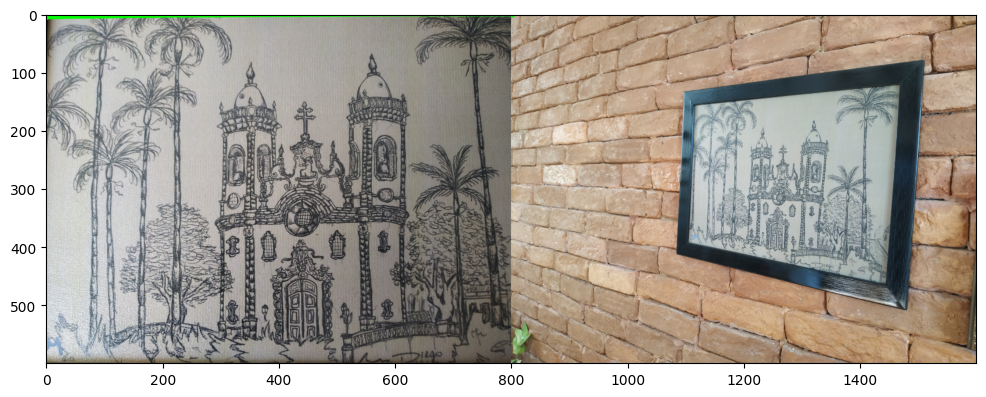

In [23]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to preprocess images
def preprocess_image(image, target_shape):
    batch_size, channels, height, width = target_shape
    
    # Resize the image to the target height and width
    resized_img = cv2.resize(image, (width, height))
    
    # Ensure image has 3 channels (RGB)
    if resized_img.shape[2] != channels:
        raise ValueError(f"Expected {channels} channels but got {resized_img.shape[2]} channels")

    # Convert to RGB if necessary
    if resized_img.shape[2] == 4:  # Check for RGBA
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_RGBA2RGB)
    
    # Normalize image
    img = resized_img.astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Add batch dimension
    img = np.transpose(img, (2, 0, 1))  # Change shape from [height, width, channels] to [channels, height, width]
    img = np.expand_dims(img, axis=0)  # Add batch dimension: Shape [1, channels, height, width]
    
    return img

# Function to warp corners and draw matches
def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

# Load and preprocess images
im1 = cv2.imread('./assets/ref.png')
im2 = cv2.imread('./assets/tgt.png')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input details to understand the required shape
print("Input details:", input_details)
input_shape = input_details[0]['shape']  # This should give you the required shape

# Preprocess images to match model's input shape
preprocessed_im1 = preprocess_image(im1, input_shape)
preprocessed_im2 = preprocess_image(im2, input_shape)

# Print shapes for debugging
print(f"Preprocessed image 1 shape: {preprocessed_im1.shape}")
print(f"Preprocessed image 2 shape: {preprocessed_im2.shape}")

# Run inference on the first image (reference)
interpreter.set_tensor(input_details[0]['index'], preprocessed_im1)
interpreter.invoke()
output_im1 = interpreter.get_tensor(output_details[0]['index'])

# Run inference on the second image (target)
interpreter.set_tensor(input_details[0]['index'], preprocessed_im2)
interpreter.invoke()
output_im2 = interpreter.get_tensor(output_details[0]['index'])

# Assuming output_im1 and output_im2 contain the keypoints
# Convert output tensors to keypoints if necessary
# Ensure the keypoints are in the format [x, y] for cv2.KeyPoint
mkpts_0 = output_im1[0]  # Extract keypoints from the output
mkpts_1 = output_im2[0]  # Extract keypoints from the output

# Ensure the keypoints are in the format (x, y)
mkpts_0 = np.array(mkpts_0).reshape(-1, 2)
mkpts_1 = np.array(mkpts_1).reshape(-1, 2)

# Debugging: Print keypoints
print(f"Keypoints in image 1: {mkpts_0}")
print(f"Keypoints in image 2: {mkpts_1}")

# Draw the matches
canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1])  # Convert BGR to RGB for matplotlib
plt.show()


In [22]:
input_details = interpreter.get_input_details()
print("Input details:", input_details)


Input details: [{'name': 'serving_default_test_input:0', 'index': 0, 'shape': array([  1,   3, 480, 640]), 'shape_signature': array([ -1,   3, 480, 640]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
